In [1]:
from scipy.io import netcdf
import numpy
import netCDF4
import pandas
import aacgmv2
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ampFName = "../data/20110516.0000.86400.120.north.grd.ncdf"
startDate = datetime.datetime( 2011, 5, 16, 8, 15 )
selDate = datetime.datetime( 2011, 5, 16, 8, 20 )
endDate = datetime.datetime( 2011, 5, 16, 8, 45 )
delTime = datetime.timedelta(minutes=4)
coords = "mlt"

In [3]:
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-05-16,2011-05-16 00:10:00,89.0,0.0,82.529999,60.080002,76.720001,67.349998,-2.50,-0.21
1,2011-05-16,2011-05-16 00:10:00,88.0,0.0,80.660004,31.370001,76.199997,41.020000,-2.55,-0.27
2,2011-05-16,2011-05-16 00:10:00,87.0,0.0,61.980000,1.050000,61.169998,10.080000,4.62,-0.28
3,2011-05-16,2011-05-16 00:10:00,86.0,0.0,32.880001,-19.570000,35.610001,-13.990000,13.99,-0.25
4,2011-05-16,2011-05-16 00:10:00,85.0,0.0,9.180000,-25.520000,13.440000,-23.559999,22.02,-0.18


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


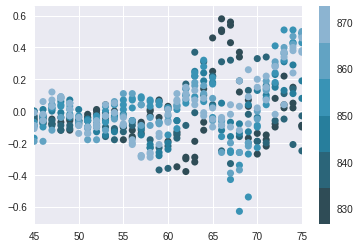

In [4]:
seaMap = ListedColormap(sns.color_palette("PuBuGn_d"))
selMlt = 22.

fig = plt.figure()
ax = fig.add_subplot(111)

selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == selMlt) & (numpy.abs(ampDF["Jr"])>=0.)) ]
selDF["time"] = selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=50,c=selDF['time'],
                  edgecolors='none', marker='o', cmap=seaMap) 
ax.set_xlim( [45, 75] )
cb = fig.colorbar(smap, orientation='vertical')
# cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))
fig.savefig( "../plots/mltAmpTime.pdf",bbox_inches='tight' )

In [5]:
# Isolate SCW!!!
# Set some cutoffs
# SCW MLTs
# Need a trend! Atleast a crude one.
mltSCWList = [ 21., 22., 23., 0., 1. ]
# jr Cutoff
jrSCWCutoff = 0.1
# MLAT Limit
mlatSCWRng = [ 50., 70. ]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


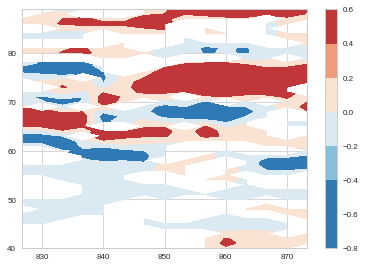

In [7]:
seaMap = ListedColormap(sns.color_palette("RdBu_r"))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == 22) & (numpy.abs(ampDF["Jr"])>=0.05)) ]
selDF["time"] = selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
ampPlot = ax.contourf(timeCntr, mlatCntr, plotAmpDF["Jr"].values.T, cmap=seaMap, vmin=-0.4,vmax=0.4)
cbar = plt.colorbar(ampPlot, orientation='vertical')
cbar.set_clim(-0.5, 0.5)
fig.savefig( "../plots/cntrSCW.pdf",bbox_inches='tight' )